In [87]:
import numpy as np
import scipy

import torch
from torch.utils.data import DataLoader

import librosa
from hyperparameters import *

from custom_datasets import MelCelebDataset
from preprocessing import melspectrogram

from IPython.display import Audio
from matplotlib import pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook as tqdm

from VGGish import vggish

import warnings


warnings.filterwarnings('ignore')
sns.set()

In [2]:
def random_crop(x, crop_size=96):
    i = np.random.randint(0, x.shape[1] - crop_size)
    return x[:, i:i+crop_size]


def show(audio):
    display(Audio(audio, rate=SAMPLE_RATE))

In [72]:
data = MelCelebDataset(MEL_DATA_PATH, 'train', user_regexp='(0|1|2|3|4|5|6|7|8|9)')
len(data)

2135

In [73]:
data[0][0]

tensor([[0.3689, 0.3354, 0.3297,  ..., 0.3194, 0.3409, 0.3471],
        [0.3487, 0.3374, 0.3206,  ..., 0.3411, 0.3682, 0.3912],
        [0.2234, 0.2418, 0.2009,  ..., 0.3521, 0.3996, 0.4079],
        ...,
        [0.3949, 0.2929, 0.2977,  ..., 0.2136, 0.2103, 0.1931],
        [0.4217, 0.4119, 0.4184,  ..., 0.1696, 0.2248, 0.1758],
        [0.3828, 0.3789, 0.3923,  ..., 0.1638, 0.1681, 0.1638]])

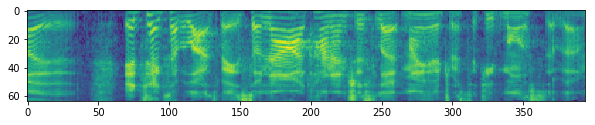

In [74]:
plt.figure(figsize=[10, 3])
plt.imshow(data[0][0])

In [75]:
data_loader = DataLoader(data, batch_size=16, num_workers=16, shuffle=True)

In [76]:
for i in tqdm(data_loader):
    pass

In [77]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = vggish(include_classifier=False, pretrained=True).to(device)
net.eval()

VGGish(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)

In [78]:
net

VGGish(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)

In [79]:
x = data[0][0].unsqueeze(0).to(device)
x, net(x).shape

(tensor([[[0.3689, 0.3354, 0.3297,  ..., 0.3194, 0.3409, 0.3471],
          [0.3487, 0.3374, 0.3206,  ..., 0.3411, 0.3682, 0.3912],
          [0.2234, 0.2418, 0.2009,  ..., 0.3521, 0.3996, 0.4079],
          ...,
          [0.3949, 0.2929, 0.2977,  ..., 0.2136, 0.2103, 0.1931],
          [0.4217, 0.4119, 0.4184,  ..., 0.1696, 0.2248, 0.1758],
          [0.3828, 0.3789, 0.3923,  ..., 0.1638, 0.1681, 0.1638]]],
        device='cuda:0'), torch.Size([1, 512, 4]))

In [80]:
from collections import defaultdict
from sklearn.manifold import TSNE


X_raw = []
y_raw = []
for i, (X, y) in enumerate(tqdm(data_loader)):
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad():
        embeddings = net(X).view(len(X), -1)
        for j in range(len(y)):
            X_raw.append(embeddings[j].cpu().numpy())
            y_raw.append(int(y[j].item()))
    del X, y

In [81]:
X_raw = np.stack(X_raw)
y_raw = np.array(y_raw, dtype=int)

In [82]:
X_embedded = TSNE(n_components=2).fit_transform(X_raw)

In [83]:
X_embedded

array([[  4.27529  ,  36.016968 ],
       [-30.50785  ,  19.37458  ],
       [ 45.45121  ,  16.356886 ],
       ...,
       [ -5.7089596,  45.43867  ],
       [-14.396604 , -24.358768 ],
       [ 13.587764 , -20.851463 ]], dtype=float32)

In [84]:
y_raw.shape, X_embedded.shape

((2135,), (2135, 2))

No handles with labels found to put in legend.


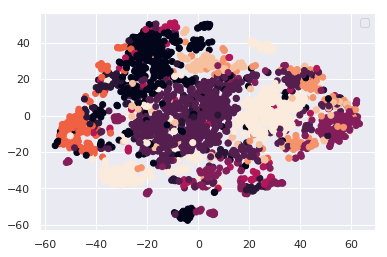

In [88]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_raw)
plt.legend()